In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer

# spacy for lemmatization
import spacy

#nltk
from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
def clean_address(row):
    name =  row.lower().split('/')
    if  row.lower().startswith('https') or  row.lower().startswith('http'):       
        return name[3]
    elif row.lower().startswith('www'):
        return name[1] 
    elif row.lower().startswith('facebook'):
        return name[1]
    else:
        print("Not found", row)
        return None

### Read csv

In [3]:
posts = pd.read_csv("cscwDocs/LatinMediaAll_Pages_Spanish.csv")
posts.shape

/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(34845, 31)

## Tokenize words and Clean-up text

In [4]:
posts['cleanMessage'] = posts['Message'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
posts['cleanMessage'].shape

(34845,)

In [5]:
# Convert to list
data = posts.cleanMessage.tolist()

In [6]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:2])

[['la', 'ex', 'primera', 'dama', 'de', 'estados', 'unidos', 'michelle', 'obama', 'dio', 'un', 'apasionado', 'discurso', 'en', 'el', 'que', 'hablo', 'del', 'caracter', 'de', 'joe', 'biden', 'para', 'convertirse', 'en', 'presidente', 'lo', 'contrasto', 'con', 'una', 'fuerte', 'critica', 'la', 'administracion', 'del', 'presidente', 'donald', 'trump', 'por', 'su', 'manejo', 'de', 'la', 'pandemia', 'las', 'tensiones', 'raciales', 'en', 'el', 'pais', 'entre', 'otros', 'temas', 'no', 'puede', 'afrontar', 'este', 'momento', 'simplemente', 'no', 'puede', 'ser', 'quien', 'necesitamos', 'que', 'sea', 'para', 'nosotros', 'dijo', 'obama', 'la', 'ex', 'primera', 'dama', 'dijo', 'que', 'biden', 'comprende', 'las', 'perdidas', 'que', 'enfrentan', 'muchos', 'estadounidenses', 'en', 'este', 'momento', 'pues', 'el', 'mismo', 'ha', 'tenido', 'perdidas', 'inimaginables', 'su', 'vida', 'es', 'un', 'testimonio', 'de', 'que', 'se', 'ha', 'recuperado', 'va', 'canalizar', 'esa', 'misma', 'determinacion', 'pasio

#### Creating Bigram and Trigram Models

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['la', 'ex', 'primera_dama', 'de', 'estados', 'unidos', 'michelle_obama', 'dio', 'un', 'apasionado', 'discurso', 'en', 'el', 'que', 'hablo', 'del', 'caracter', 'de', 'joe', 'biden', 'para', 'convertirse', 'en', 'presidente', 'lo', 'contrasto', 'con', 'una', 'fuerte_critica', 'la', 'administracion', 'del', 'presidente', 'donald', 'trump', 'por', 'su', 'manejo', 'de', 'la', 'pandemia', 'las', 'tensiones', 'raciales', 'en', 'el', 'pais', 'entre', 'otros', 'temas', 'no', 'puede', 'afrontar', 'este', 'momento', 'simplemente', 'no', 'puede', 'ser', 'quien', 'necesitamos', 'que', 'sea', 'para', 'nosotros', 'dijo', 'obama', 'la', 'ex', 'primera_dama', 'dijo', 'que', 'biden', 'comprende', 'las', 'perdidas', 'que', 'enfrentan', 'muchos', 'estadounidenses', 'en', 'este', 'momento', 'pues', 'el', 'mismo', 'ha', 'tenido', 'perdidas', 'inimaginables', 'su', 'vida', 'es', 'un', 'testimonio', 'de', 'que', 'se', 'ha', 'recuperado', 'va', 'canalizar', 'esa', 'misma', 'determinacion', 'pasion', 'para', '

## Remove Stopwords, Make Bigrams and Lemmatize

In [9]:
stop_words = stopwords.words('spanish')
#stop_words.extend(stopwords.words('english'))
stop_words.extend(['su','sus','al','de','en','el','tal','con','mas','si','dos','pm','ser','ex','could','like','would','get','many','much','\ufeff1'])

In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)


#Spanish use the following:
#!python3 -m spacy download es_core_news_sm
nlp = spacy.load('es_core_news_sm', disable=['parser', 'ner'])

#English use the following:
#!python3 -m spacy download en_core_web_sm
#nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [12]:
print(data_words_nostops[4:5])

[['trump', 'cierre', 'convencion', 'republicana', 'gana', 'biden', 'china', 'seria', 'dueno', 'unidos']]


## Bag of Words

In [13]:
def combine_words(word1,word2,dictionary):

    if word1 in dictionary and word2 in dictionary:
        concat_name = word1+" / "+word2
        dictionary[concat_name] = dictionary[word1] + dictionary[word2]
        dictionary.pop(word1, None)
        dictionary.pop(word2, None)
        result = dictionary.pop(word1, None)
        result = dictionary.pop(word2, None)
    return dictionary

In [14]:
flat_list_words = [item for sublist in data_lemmatized for item in sublist]
count_words = Counter(flat_list_words)

In [15]:
final_dict = combine_words('donald','trump',count_words)
final_dict = combine_words('joe','biden',count_words)
final_dict = combine_words('kamala','harris',count_words)
final_dict = combine_words('american','america',count_words)
final_dict = combine_words('estados','unidos',count_words)
final_dict = combine_words('voters','vote',count_words)
final_dict = combine_words('mexico','mexican',count_words)
final_dict = combine_words('casa','blanca',count_words)
final_dict = combine_words('venezuela','venezuelans',count_words)
final_dict = combine_words('latino','latinos',count_words)
final_dict = combine_words('american / america','americans',count_words)
final_dict = combine_words('voters / vote','voting',count_words)
final_dict = combine_words('puerto','rico',count_words)
final_dict = combine_words('communism','communist',count_words)
final_dict = combine_words('ee','uu',count_words)
final_dict = combine_words('united','states',count_words)

In [16]:
final_dict.most_common(1000)

[('donald / trump', 29545),
 ('joe / biden', 10562),
 ('presidente', 10147),
 ('decir', 5692),
 ('elección', 3793),
 ('debatir', 3299),
 ('coronavirus', 3168),
 ('unir', 2996),
 ('candidato', 2921),
 ('democrata', 2861),
 ('covid', 2783),
 ('destinar', 2570),
 ('casar', 2486),
 ('campana', 2435),
 ('presidencial', 2414),
 ('dar', 2350),
 ('votar', 2211),
 ('hacer', 2205),
 ('blanco', 2201),
 ('http', 2192),
 ('republicano', 2114),
 ('partir', 1977),
 ('aqui', 1834),
 ('gobernar', 1826),
 ('ano', 1745),
 ('pais', 1624),
 ('convencion', 1581),
 ('hoy', 1464),
 ('anunciar', 1428),
 ('personar', 1374),
 ('florido', 1362),
 ('noviembre', 1361),
 ('detalle', 1345),
 ('mirar', 1325),
 ('nacional', 1322),
 ('estadounidense', 1256),
 ('apoyar', 1208),
 ('dias', 1201),
 ('despues', 1194),
 ('ultimar', 1183),
 ('mandatario', 1183),
 ('contar', 1149),
 ('nuevo', 1144),
 ('politica', 1142),
 ('noche', 1112),
 ('dia', 1102),
 ('hablar', 1098),
 ('positivo', 1096),
 ('semana', 1091),
 ('kamala_harris

In [17]:
docs = ([' '.join(ele) for ele in data_lemmatized] )


In [18]:
cv=CountVectorizer() 
word_count_vector=cv.fit_transform(docs)
#word_count_vector.toarray()

# Convert bow_matrix into a DataFrame
bow_df = pd.DataFrame(word_count_vector.toarray())

# Map the column names to vocabulary 
bow_df.columns = cv.get_feature_names()

# Print bow_df
print(bow_df)

       14  19  25  26  aaron  aaron_ford  aarondfordnv  aarp  aaz  ab  ...  \
0       0   0   0   0      0           0             0     0    0   0  ...   
1       0   0   0   0      0           0             0     0    0   0  ...   
2       0   0   0   0      0           0             0     0    0   0  ...   
3       0   0   0   0      0           0             0     0    0   0  ...   
4       0   0   0   0      0           0             0     0    0   0  ...   
...    ..  ..  ..  ..    ...         ...           ...   ...  ...  ..  ...   
34840   0   0   0   0      0           0             0     0    0   0  ...   
34841   0   0   0   0      0           0             0     0    0   0  ...   
34842   0   0   0   0      0           0             0     0    0   0  ...   
34843   0   0   0   0      0           0             0     0    0   0  ...   
34844   0   0   0   0      0           0             0     0    0   0  ...   

       𝗽𝗮i𝘀  𝗽𝗼𝗱𝗲𝗿  𝘀𝗲𝗴𝘂𝗶𝗿  𝘀𝗶  𝘀𝗶𝗻  𝘀𝘂  𝘁𝗿𝗮𝘁𝗮𝗿  𝘂𝘁𝗶𝗹𝗶𝘇𝗮𝗻𝗱𝗼  𝙉𝙤

### TF-IDF

In [19]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [20]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
trump,1.554007
presidente,2.303443
donald,2.618693
biden,2.657525
decir,2.929770
...,...
pressure,10.765546
presse,10.765546
press,10.765546
coincidencia,10.765546


In [21]:
# count matrix 
count_vector=cv.transform(docs) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [22]:
feature_names = cv.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df = df[(df != 0).all(1)]
df.sort_values(by=["tfidf"],ascending=False).to_csv("outlets_tfidf.csv")

In [23]:
df

,tfidf
adelantar,0.109597
administracion,0.074515
afrontar,0.131908
agarrar,0.148645
apasionar,0.146778
...,...
unir,0.056208
vez,0.072252
vida,0.089743
votar,0.124341


## Topic Modeling
### Create the Dictionary and Corpus needed for Topic Modeling

In [24]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 3), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 3), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 1), (32, 2), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 2), (48, 1), (49, 1), (50, 2), (51, 2), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 2), (65, 1)]]


[[('adelantar', 1),
  ('administracion', 1),
  ('afrontar', 1),
  ('agarrar', 1),
  ('apasionar', 1),
  ('aqui', 1),
  ('ayudarnos', 1),
  ('biden', 3),
  ('bolsa', 1),
  ('canalizar', 1),
  ('caracter', 1),
  ('cenar', 1),
  ('comodos', 1),
  ('comprender', 1),
  ('contrastar', 1),
  ('convertirse', 1),
  ('dar', 1),
  ('decir', 3),
  ('desayunar', 1),
  ('determinacion', 1),
  ('discursar', 1),
  ('disponer', 1),
  ('donald', 1),
  ('enfrentar', 1),
  ('estadounidense', 1),
  ('fila', 1),
  ('fuerte_critica', 1),
  ('guiarnos', 1),
  ('hablar', 1),
  ('hacer', 2),
  ('ignorar', 1),
  ('inimaginable', 1),
  ('joe', 2),
  ('levantarnos', 1),
  ('llamar', 1),
  ('manejar', 1),
  ('mascarilla', 1),
  ('michelle_obama', 1),
  ('mirar', 1),
  ('momento', 2),
  ('necesario', 1),
  ('necesitar', 1),
  ('noche', 1),
  ('numeros', 1),
  ('obama', 2),
  ('pais', 1),
  ('pasion', 1),
  ('perdido', 2),
  ('ponernos', 1),
  ('preparar', 1),
  ('presidente', 2),
  ('primera_dama', 2),
  ('racial', 

## Building the Topic Model

In [25]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model

In [26]:
# Print the Keyword in the 10 topics
#The weights reflect how important a keyword is to that topic.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.489*"trump" + 0.171*"donald" + 0.146*"presidente" + 0.040*"pais" + '
  '0.032*"personar" + 0.029*"covid" + 0.024*"estadounidense" + '
  '0.008*"cantante" + 0.007*"muerte" + 0.007*"expresar"'),
 (1,
  '0.207*"millón" + 0.148*"mirar" + 0.130*"estan" + 0.113*"asegurar" + '
  '0.054*"eleccion" + 0.046*"usar" + 0.037*"directo" + 0.026*"vida" + '
  '0.023*"gente" + 0.021*"estilar"'),
 (2,
  '0.163*"encuestar" + 0.132*"ano" + 0.113*"administracion" + 0.088*"semana" + '
  '0.067*"mitin" + 0.066*"ayudar" + 0.065*"solo" + 0.062*"despues" + '
  '0.051*"anunciar" + 0.033*"lunes"'),
 (3,
  '0.440*"candidato" + 0.102*"kamala_harris" + 0.071*"trabajar" + '
  '0.061*"vicepresidencia" + 0.055*"vivir" + 0.041*"revelar" + 0.040*"pesar" + '
  '0.033*"gran" + 0.026*"mesar" + 0.012*"rodear"'),
 (4,
  '0.248*"hacer" + 0.114*"pasar" + 0.106*"nuevo" + 0.100*"texas" + '
  '0.078*"frontero" + 0.039*"preparar" + 0.034*"perder" + 0.024*"seguro" + '
  '0.019*"cifrar" + 0.019*"alcanzar"'),
 (5,
  '0.128*"p

## Compute Model Perplexity and Coherence Score


In [27]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -19.55993349374213

Coherence Score:  0.3369845380518038


## Visualize the topics-keywords

In [28]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.308033 -0.362705       1        1  23.352805
11    -0.218784  0.221764       2        1  11.187136
17    -0.218998  0.210396       3        1  10.204800
18    -0.129348  0.043715       4        1   6.866351
2     -0.053600  0.010786       5        1   5.358658
9      0.077188 -0.010778       6        1   4.171269
1     -0.025319  0.003756       7        1   3.858840
12     0.001141 -0.001068       8        1   3.855975
4      0.013942 -0.003299       9        1   3.673305
13     0.048424 -0.007875      10        1   3.324193
3      0.042251 -0.007059      11        1   3.296748
8      0.067833 -0.009936      12        1   3.222396
19     0.049320 -0.007967      13        1   2.957062
15     0.030135 -0.005473      14        1   2.811421
5      0.078933 -0.010908      15        1   2.662476
7      0.062806 -0.009410      16        1   2.435838
10     0.102238 -0.012678      17        1   2.345481
14     0.110324 -0.013140      18        1   1.901545
16     0.115278 -0.013442      19        1   1.536328
6      0.154269 -0.014678      20        1   0.977373, topic_info=          Term          Freq         Total Category  logprob  loglift
60       trump  56336.000000  56336.000000  Default  30.0000  30.0000
7        biden  21644.000000  21644.000000  Default  29.0000  29.0000
17       decir  13451.000000  13451.000000  Default  28.0000  28.0000
325   elección  13741.000000  13741.000000  Default  27.0000  27.0000
22      donald  19758.000000  19758.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
687    votante      0.082909      1.896478  Topic20 -10.9713   1.4981
1465    llegar      0.082905      1.896044  Topic20 -10.9713   1.4982
628     contar      0.082902      1.896057  Topic20 -10.9714   1.4982
1410      dias      0.082902      1.896304  Topic20 -10.9714   1.4981
762       voto      0.082902      1.896637  Topic20 -10.9714   1.4979

[836 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
491       9  0.992690    abrir
175       8  0.996874   acabar
142      17  0.991901  aceptar
307       2  0.998827   actual
445      12  0.996728   acusar
...     ...       ...      ...
382      11  0.997799    vivir
92        2  0.996535   volver
64        4  0.999774    votar
433       8  0.993361      voz
338       3  0.997229       ﻿1

[348 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 12, 18, 19, 3, 10, 2, 13, 5, 14, 4, 9, 20, 16, 6, 8, 11, 15, 17, 7])

## Building LDA Mallet Model

In [29]:
import os
os.getcwd()
!pwd

/Users/claudia/Documents/Latinx2020


In [34]:

# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [35]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(13,
  [('trump', 0.1534154535274356),
   ('presidente', 0.07623395641312775),
   ('donald', 0.05060728744939271),
   ('partir', 0.038246188302179344),
   ('coronavirus', 0.03376690498750969),
   ('unir', 0.03251787406322681),
   ('eeuu', 0.02773710052545439),
   ('mensaje', 0.025885089154965974),
   ('asegurar', 0.022913256955810146),
   ('entrevistar', 0.0189938840554742)]),
 (18,
  [('querer', 0.019828911578034455),
   ('seguridad', 0.01840974494421887),
   ('nacional', 0.014585879291993535),
   ('ley', 0.014033981156620806),
   ('administracion', 0.013797453384318209),
   ('orden', 0.013758032088934443),
   ('puerto_rico', 0.013442661725864311),
   ('armar', 0.011511018252059763),
   ('amenazar', 0.010959120116687034),
   ('usar', 0.010564907162849371)]),
 (6,
  [('trump', 0.12778303103240782),
   ('campana', 0.09584801856786727),
   ('presidente', 0.07397060087681595),
   ('donald', 0.05424224189804865),
   ('evento', 0.04521619530645577),
   ('personar', 0.024542250494283505),
 

## Finding the optimal number of topics for LDA

In [36]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [37]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

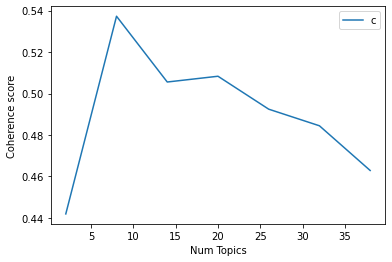

In [38]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [39]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4419
Num Topics = 8  has Coherence Value of 0.5373
Num Topics = 14  has Coherence Value of 0.5056
Num Topics = 20  has Coherence Value of 0.5084
Num Topics = 26  has Coherence Value of 0.4925
Num Topics = 32  has Coherence Value of 0.4845
Num Topics = 38  has Coherence Value of 0.4629


In [40]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.105*"trump" + 0.074*"decir" + 0.021*"presidente" + 0.016*"hacer" + '
  '0.014*"estadounidense" + 0.014*"politica" + 0.014*"asegurar" + '
  '0.013*"tratar" + 0.013*"donald" + 0.013*"eeuu"'),
 (1,
  '0.055*"presidente" + 0.051*"coronavirus" + 0.040*"trump" + 0.040*"casar" + '
  '0.039*"covid" + 0.038*"dar" + 0.035*"blanco" + 0.020*"anunciar" + '
  '0.019*"mandatario" + 0.019*"despues"'),
 (2,
  '0.020*"personar" + 0.016*"semana" + 0.014*"millón" + 0.011*"unir" + '
  '0.010*"pais" + 0.009*"trabajar" + 0.008*"usar" + 0.008*"vacuno" + '
  '0.007*"tiempo" + 0.007*"ano"'),
 (3,
  '0.093*"trump" + 0.057*"debatir" + 0.047*"biden" + 0.042*"presidencial" + '
  '0.032*"aqui" + 0.032*"donald" + 0.028*"http" + 0.023*"detalle" + '
  '0.023*"mirar" + 0.020*"contar"'),
 (4,
  '0.029*"gobernar" + 0.020*"ano" + 0.014*"administracion" + '
  '0.013*"inmigrante" + 0.010*"federal" + 0.010*"impuesto" + 0.010*"pagar" + '
  '0.008*"nacional" + 0.007*"solo" + 0.007*"seguridad"'),
 (5,
  '0.050*"elecció

##  Finding the dominant topic in each sentence

In [41]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.1825,"trump, decir, presidente, hacer, estadounidens...",La ex primera dama de Estados Unidos Michelle ...
1,1,0.0,0.1356,"trump, decir, presidente, hacer, estadounidens...",Eso es lo que dicen...
2,2,0.0,0.1654,"trump, decir, presidente, hacer, estadounidens...","""Su creencia en la santidad de la vida trascie..."
3,3,2.0,0.2161,"personar, semana, millón, unir, pais, trabajar...",En momentos donde la pandemia golpea con fuerz...
4,4,7.0,0.1745,"biden, joe, candidato, democrata, destinar, re...",Trump en el cierre de la Convención Republican...
5,5,2.0,0.1843,"personar, semana, millón, unir, pais, trabajar...",Trump extendió el plazo sin pagos mediante una...
6,6,2.0,0.1964,"personar, semana, millón, unir, pais, trabajar...",El Gobierno de Donald Trump planea extraer gas...
7,7,6.0,0.1434,"trump, presidente, donald, noticiar, juez, cor...","""LO ESTÁ RODEANDO LA MUERTE"". Mhoni Vidente re..."
8,8,0.0,0.1557,"trump, decir, presidente, hacer, estadounidens...","Y sí, nos quería cambiar por Groenlandia..."
9,9,2.0,0.1452,"personar, semana, millón, unir, pais, trabajar...",El presidente de EE.UU. sugirió comprar Groenl...


## Find the most representative document for each topic

In [42]:
#We will find the documents a given topic has contributed to the most and infer the topic by reading that document.
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
#pd.set_option('display.max_colwidth', None)
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4716,"trump, decir, presidente, hacer, estadounidens...",Trump supuestamente tildó de estúpida la guerr...
1,1.0,0.5099,"presidente, coronavirus, trump, casar, covid, ...",Trump y la primera dama Melania dan positivo p...
2,2.0,0.6633,"personar, semana, millón, unir, pais, trabajar...","Suben a 1,1 millones los pedidos semanales del..."
3,3.0,0.3667,"trump, debatir, biden, presidencial, aqui, don...","🎥 En Nashville, Tennessee será el último debat..."
4,4.0,0.6449,"gobernar, ano, administracion, inmigrante, fed...",[LOCALES] Codepola defiende evento en el que l...


In [43]:
## Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.dropna(inplace=True)
pd.set_option('display.max_colwidth', None)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"trump, decir, presidente, hacer, estadounidense, politica, asegurar, tratar, donald, eeuu",4211.0,0.1208
1.0,0.0,"trump, decir, presidente, hacer, estadounidense, politica, asegurar, tratar, donald, eeuu",5065.0,0.1454
2.0,0.0,"trump, decir, presidente, hacer, estadounidense, politica, asegurar, tratar, donald, eeuu",3418.0,0.0981
3.0,2.0,"personar, semana, millón, unir, pais, trabajar, usar, vacuno, tiempo, ano",4897.0,0.1405
4.0,7.0,"biden, joe, candidato, democrata, destinar, republicano, campana, partir, convencion, kamala_harris",4464.0,0.1281
5.0,2.0,"personar, semana, millón, unir, pais, trabajar, usar, vacuno, tiempo, ano",4495.0,0.1290
6.0,2.0,"personar, semana, millón, unir, pais, trabajar, usar, vacuno, tiempo, ano",3477.0,0.0998
7.0,6.0,"trump, presidente, donald, noticiar, juez, corte_suprema, ultimahora, unir, dia, martes",4818.0,0.1383
